<a href="https://colab.research.google.com/github/dartwinshu/dibimbing-machine-learning-application/blob/main/Dibimbing%20-%20Machine%20Learning%20Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Home Credit Default Risk

## Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. 

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Moreover, we are provided with the definitions of all the columns (in `HomeCredit_columns_description.csv`) and an example of the expected submission file.

## Metric: ROC AUC

Once we have a grasp of the data (reading through the [column descriptions](https://www.kaggle.com/c/home-credit-default-risk/data) helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

The ROC AUC may sound intimidating, but it is relatively straightforward once you can get your head around the two individual concepts. The [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) graphs the true positive rate versus the false positive rate:

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model. 

The [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalanced classes (we will see this is the case), accuracy is not the best metric. For example, if I wanted to build a model that could detect terrorists with 99.9999% accuracy, I would simply make a model that predicted every single person was not a terrorist. Clearly, this would not be effective (the recall would be zero) and we use more advanced metrics such as ROC AUC or the [F1 score](https://en.wikipedia.org/wiki/F1_score) to more accurately reflect the performance of a classifier. A model with a high ROC AUC will also have a high accuracy, but the [ROC AUC is a better representation of model performance.](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)

## List of Check Point
- CP #1 : Preparation 
- CP #2 : Data Quick look 
- CP #3 : Miscellaneous Handling
- CP #4 : Selection & Subset
- CP #5 : Transformation
- CP #6: Joining table
- CP #7: Aggregation & Sorting
- CP #8: Visualization
- CP #9: Dummy Var & Split Data
- CP #10 : Modeling


# 1. Preparation

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [2]:
application_train = pd.read_csv('application_train.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
installments_payments = pd.read_csv('installments_payments.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
bureau = pd.read_csv('bureau.csv')
application_test = pd.read_csv('application_test.csv')

In [3]:
## sampling dataset
# application_train = application_train.sample(40000)

In [4]:
application_train.shape

(307511, 122)

# 2. Data Quick Look

## Data Shape

In [5]:
print('Size of application_train data', application_train.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)
print('Size of application_test data', application_test.shape)

Size of application_train data (307511, 122)
Size of POS_CASH_balance data (4910845, 8)
Size of bureau_balance data (14104024, 3)
Size of previous_application data (794129, 37)
Size of installments_payments data (3629937, 8)
Size of credit_card_balance data (1759692, 23)
Size of bureau data (1716428, 17)
Size of application_test data (48744, 121)


## Concat Training and Testing Dataset

In [6]:
application_mix = pd.concat([application_train,application_test],0).reset_index(drop=True)
print('Size of application training and testing data', application_mix.shape)

Size of application training and testing data (356255, 122)


## Data View and Data Type

In [7]:
application_mix.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
application_mix['TARGET'].unique()

array([ 1.,  0., nan])

In [9]:
application_mix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(40), object(16)
memory usage: 331.6+ MB


In [10]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31.0,48.0,45.0,Active,0.0,0.0
1,1715348,367990,-33.0,36.0,35.0,Active,0.0,0.0
2,1784872,397406,-32.0,12.0,9.0,Active,0.0,0.0
3,1903291,269225,-35.0,48.0,42.0,Active,0.0,0.0
4,2341044,334279,-35.0,36.0,35.0,Active,0.0,0.0


In [11]:
POS_CASH_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4910845 entries, 0 to 4910844
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         float64
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 float64
 7   SK_DPD_DEF             float64
dtypes: float64(5), int64(2), object(1)
memory usage: 299.7+ MB


In [12]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0.0,C
1,5715448,-1.0,C
2,5715448,-2.0,C
3,5715448,-3.0,C
4,5715448,-4.0,C


In [13]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14104024 entries, 0 to 14104023
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   SK_ID_BUREAU    int64  
 1   MONTHS_BALANCE  float64
 2   STATUS          object 
dtypes: float64(1), int64(1), object(1)
memory usage: 322.8+ MB


In [14]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794129 entries, 0 to 794128
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_PREV                   794129 non-null  int64  
 1   SK_ID_CURR                   794129 non-null  int64  
 2   NAME_CONTRACT_TYPE           794129 non-null  object 
 3   AMT_ANNUITY                  618348 non-null  float64
 4   AMT_APPLICATION              794129 non-null  float64
 5   AMT_CREDIT                   794129 non-null  float64
 6   AMT_DOWN_PAYMENT             372972 non-null  float64
 7   AMT_GOODS_PRICE              612503 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   794129 non-null  object 
 9   HOUR_APPR_PROCESS_START      794129 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  794129 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       794129 non-null  int64  
 12  RATE_DOWN_PAYMENT            372972 non-null  float64
 13 

In [16]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6.0,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34.0,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1.0,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3.0,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2.0,-1383.0,-1366.0,2165.040,2160.585


In [17]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3629937 entries, 0 to 3629936
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   float64
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(6), int64(2)
memory usage: 221.6 MB


In [18]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907.0,-6.0,56.970,135000.0,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1.0,0.0,1.0,35.0,Active,0.0,0.0
1,2582071,363914.0,-1.0,63975.555,45000.0,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1.0,0.0,0.0,69.0,Active,0.0,0.0
2,1740877,371185.0,-7.0,31815.225,450000.0,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0.0,0.0,0.0,30.0,Active,0.0,0.0
3,1389973,337855.0,-4.0,236572.110,225000.0,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1.0,0.0,0.0,10.0,Active,0.0,0.0
4,1891521,126868.0,-1.0,453919.455,450000.0,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1.0,0.0,1.0,101.0,Active,0.0,0.0


In [19]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759692 entries, 0 to 1759691
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  float64
 2   MONTHS_BALANCE              float64
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     float64
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        float64
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [20]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [21]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


## Number of Target

In [22]:
application_mix['TARGET'].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [23]:
application_mix['TARGET'].value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

## Statistics Desriptive

In [24]:
application_mix.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,307511.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,...,356255.000000,356255.000000,356255.000000,356255.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000
mean,278128.000000,0.080729,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,...,0.007231,0.000514,0.000438,0.000289,0.005808,0.006281,0.029995,0.231697,0.304399,1.911564
std,102842.104413,0.272419,0.720378,2.235068e+05,3.986237e+05,14732.808190,3.660650e+05,0.013915,4358.803980,141705.532576,...,0.084726,0.022659,0.020921,0.017001,0.079736,0.104250,0.191374,0.855949,0.786915,1.865338
min,100001.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000253,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189064.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,2.340000e+05,0.010006,-19676.000000,-2781.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278128.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,4.500000e+05,0.018850,-15755.000000,-1224.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367191.500000,0.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,6.750000e+05,0.028663,-12425.000000,-290.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7338.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


# 2.5 Exploratory Data Analysis

### Target Feature

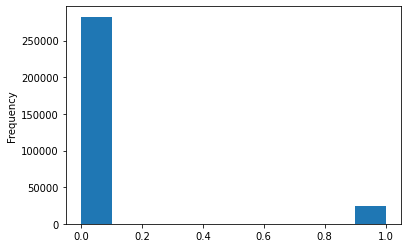

In [25]:
application_mix['TARGET'].plot.hist();

### Number of Unique Category each Column

In [26]:
application_mix.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Day Birth

In [27]:
(application_mix['DAYS_BIRTH']).describe()

count    356255.000000
mean     -16041.248841
std        4358.803980
min      -25229.000000
25%      -19676.000000
50%      -15755.000000
75%      -12425.000000
max       -7338.000000
Name: DAYS_BIRTH, dtype: float64

In [28]:
(application_mix['DAYS_BIRTH'] / -365).describe()

count    356255.000000
mean         43.948627
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### Days Employe

In [29]:
application_mix['DAYS_EMPLOYED'].describe()

count    356255.000000
mean      64317.231413
std      141705.532576
min      -17912.000000
25%       -2781.000000
50%       -1224.000000
75%        -290.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

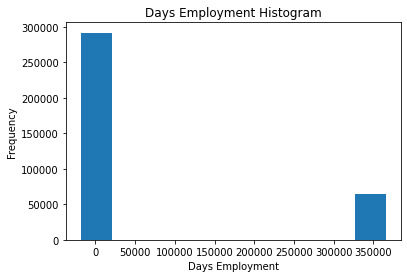

In [30]:
application_mix['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

### Risk Rate from Anomalous

In [31]:
anom = application_mix[application_mix['DAYS_EMPLOYED'] == 365243]
non_anom = application_mix[application_mix['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 64648 anomalous days of employment


### Correlations

In [32]:
# Find correlations with the target and sort
correlations = application_mix.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


In [33]:
# Find the correlation of the positive days since birth and target
application_mix['DAYS_BIRTH'] = abs(application_mix['DAYS_BIRTH'])
application_mix['DAYS_BIRTH'].corr(application_mix['TARGET'])

-0.07823930830982694

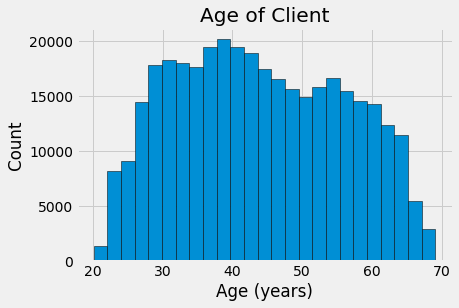

In [34]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(application_mix['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

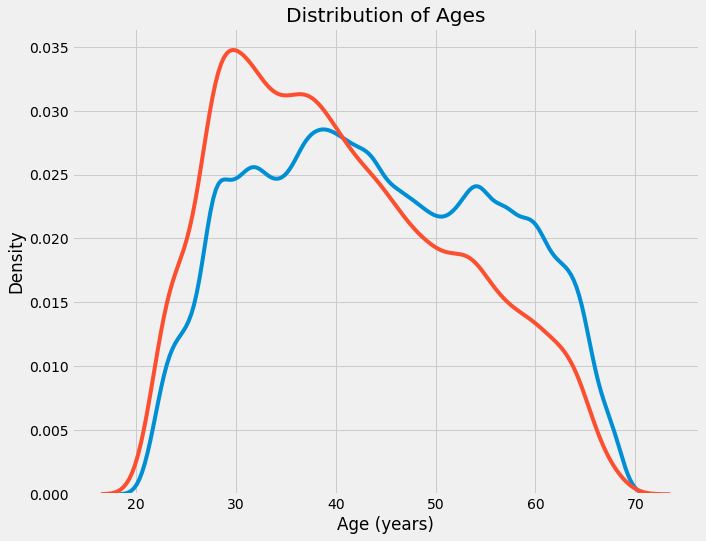

In [35]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(application_mix.loc[application_mix['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(application_mix.loc[application_mix['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [36]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = application_mix[['TARGET', 'EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.212987,0.181390,0.586844
EXT_SOURCE_2,-0.160472,0.212987,1.000000,0.108480,0.095338
EXT_SOURCE_3,-0.178919,0.181390,0.108480,1.000000,0.201932
DAYS_BIRTH,-0.078239,0.586844,0.095338,0.201932,1.000000


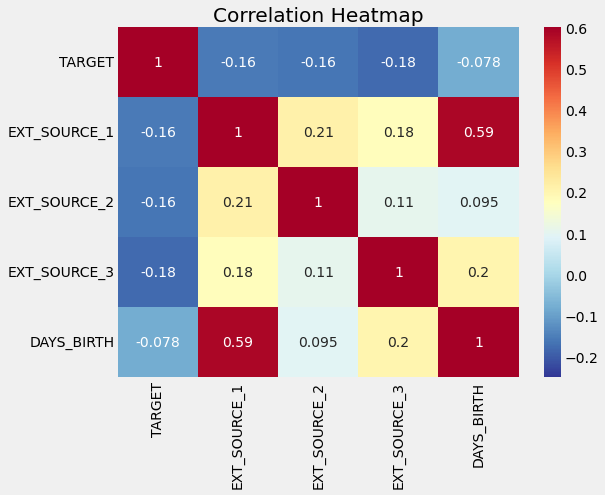

In [37]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

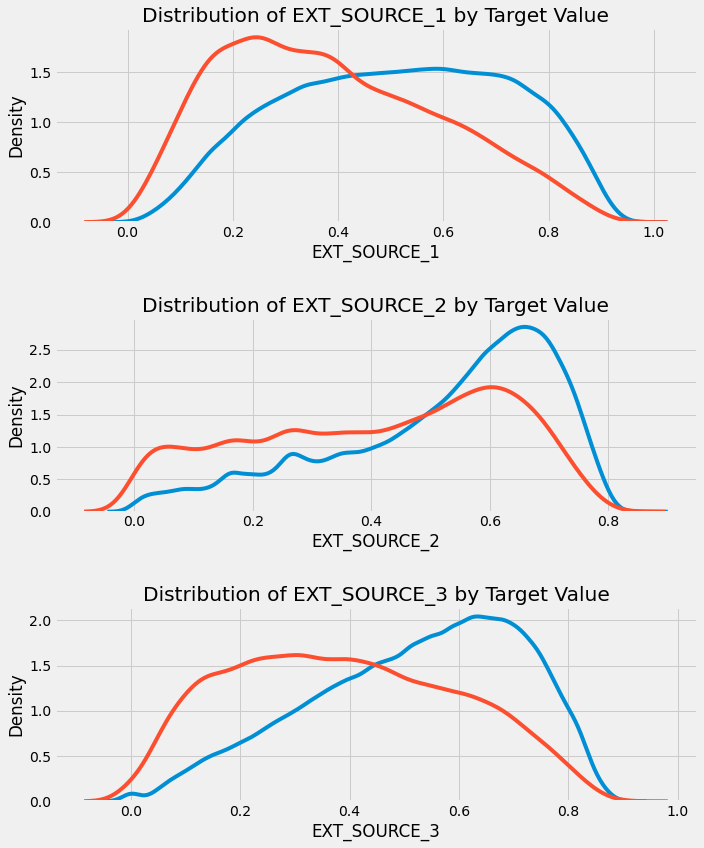

In [38]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(application_mix.loc[application_mix['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(application_mix.loc[application_mix['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

# 3. Miscellaneous Handling

## Check Missing Data

In [39]:
# checking missing data
total = application_mix.isnull().sum().sort_values(ascending = False)
percent = (application_mix.isnull().sum()/application_mix.isnull().count()*100).sort_values(ascending = False)
missing_application_mix_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_mix_data.head(20)

,Total,Percent
COMMONAREA_AVG,248360,69.714109
COMMONAREA_MODE,248360,69.714109
COMMONAREA_MEDI,248360,69.714109
NONLIVINGAPARTMENTS_AVG,246861,69.293343
NONLIVINGAPARTMENTS_MODE,246861,69.293343
NONLIVINGAPARTMENTS_MEDI,246861,69.293343
FONDKAPREMONT_MODE,243092,68.235393
LIVINGAPARTMENTS_MEDI,242979,68.203674
LIVINGAPARTMENTS_AVG,242979,68.203674
LIVINGAPARTMENTS_MODE,242979,68.203674


In [40]:
# checking missing data
total = POS_CASH_balance.isnull().sum().sort_values(ascending = False)
percent = (POS_CASH_balance.isnull().sum()/POS_CASH_balance.isnull().count()*100).sort_values(ascending = False)
missing_POS_CASH_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_POS_CASH_balance_data.head(3)

,Total,Percent
CNT_INSTALMENT_FUTURE,7510,0.152927
CNT_INSTALMENT,7506,0.152845
MONTHS_BALANCE,1,0.000020


In [41]:
# checking missing data
total = bureau_balance.isnull().sum().sort_values(ascending = False)
percent = (bureau_balance.isnull().sum()/bureau_balance.isnull().count()*100).sort_values(ascending = False)
missing_bureau_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_balance_data.head(3)

,Total,Percent
MONTHS_BALANCE,1,0.000007
STATUS,1,0.000007
SK_ID_BUREAU,0,0.000000


In [42]:
# checking missing data
total = previous_application.isnull().sum().sort_values(ascending = False)
percent = (previous_application.isnull().sum()/previous_application.isnull().count()*100).sort_values(ascending = False)
missing_previous_application_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_previous_application_data.head(15)

,Total,Percent
RATE_INTEREST_PRIMARY,791325,99.646909
RATE_INTEREST_PRIVILEGED,791325,99.646909
AMT_DOWN_PAYMENT,421157,53.033827
RATE_DOWN_PAYMENT,421157,53.033827
NAME_TYPE_SUITE,389854,49.092024
NFLAG_INSURED_ON_APPROVAL,317510,39.982169
DAYS_TERMINATION,317510,39.982169
DAYS_LAST_DUE,317510,39.982169
DAYS_LAST_DUE_1ST_VERSION,317510,39.982169
DAYS_FIRST_DUE,317510,39.982169


In [43]:
# checking missing data
total = installments_payments.isnull().sum().sort_values(ascending = False)
percent = (installments_payments.isnull().sum()/installments_payments.isnull().count()*100).sort_values(ascending = False)
missing_installments_payments_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_installments_payments_data.head(3)

,Total,Percent
NUM_INSTALMENT_NUMBER,1,0.000028
DAYS_INSTALMENT,1,0.000028
DAYS_ENTRY_PAYMENT,1,0.000028


In [44]:
# checking missing data
total = credit_card_balance.isnull().sum().sort_values(ascending = False)
percent = (credit_card_balance.isnull().sum()/credit_card_balance.isnull().count()*100).sort_values(ascending = False)
missing_credit_card_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_credit_card_balance_data.head(10)

,Total,Percent
AMT_PAYMENT_CURRENT,362604,20.606106
AMT_DRAWINGS_ATM_CURRENT,356939,20.284175
CNT_DRAWINGS_POS_CURRENT,356939,20.284175
AMT_DRAWINGS_OTHER_CURRENT,356939,20.284175
AMT_DRAWINGS_POS_CURRENT,356939,20.284175
CNT_DRAWINGS_OTHER_CURRENT,356939,20.284175
CNT_DRAWINGS_ATM_CURRENT,356939,20.284175
CNT_INSTALMENT_MATURE_CUM,129422,7.354810
AMT_INST_MIN_REGULARITY,129422,7.354810
AMT_PAYMENT_TOTAL_CURRENT,1,0.000057


In [45]:
# checking missing data
total = bureau.isnull().sum().sort_values(ascending = False)
percent = (bureau.isnull().sum()/bureau.isnull().count()*100).sort_values(ascending = False)
missing_bureau_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_data.head(8)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_ACTIVE,0,0.000000


## Checking Duplicates Value

In [46]:
print('Number of duplicated data in application_train data', application_mix.duplicated().sum())
print('Number of duplicated data in POS_CASH_balance data', POS_CASH_balance.duplicated().sum())
print('Number of duplicated data in bureau_balance data', bureau_balance.duplicated().sum())
print('Number of duplicated data in previous_application data', previous_application.duplicated().sum())
print('Number of duplicated data in installments_payments data', installments_payments.duplicated().sum())
print('Number of duplicated data in credit_card_balance data', credit_card_balance.duplicated().sum())
print('Number of duplicated data in bureau data', bureau.duplicated().sum())

Number of duplicated data in application_train data 0
Number of duplicated data in POS_CASH_balance data 0
Number of duplicated data in bureau_balance data 0
Number of duplicated data in previous_application data 0
Number of duplicated data in installments_payments data 0
Number of duplicated data in credit_card_balance data 0
Number of duplicated data in bureau data 0


## Drop Missing Value Column

In [47]:
def missing_values_stat_in_columns(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values In Column', 1 : '% of Total Values In Column'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values In Column', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    return mis_val_table_ren_columns

def missing_value_manipulation(df, missing_percentage = 30.0): # TODO: Shoul be used for generating column list to drop
    missing_percentage_df = missing_values_stat_in_columns(df)
    cols_to_drop = set()
    for index, row in missing_percentage_df.iterrows():
        if row['% of Total Values In Column'] >= float(missing_percentage):
            cols_to_drop.add(index)
#     print(cols_to_drop)
    if 'EXT_SOURCE_1' in cols_to_drop:
        cols_to_drop.remove('EXT_SOURCE_1')
    print('There are '+str(len(cols_to_drop))+' columns that have more than 30% missing value.')
    return cols_to_drop

In [48]:
application_mix = application_mix.drop(missing_value_manipulation(application_mix),1)

Your selected dataframe has 122 columns.
There are 68 columns that have missing values.
There are 49 columns that have more than 30% missing value.


In [49]:
POS_CASH_balance = POS_CASH_balance.drop(missing_value_manipulation(POS_CASH_balance),1)

Your selected dataframe has 8 columns.
There are 6 columns that have missing values.
There are 0 columns that have more than 30% missing value.


In [50]:
bureau_balance = bureau_balance.drop(missing_value_manipulation(bureau_balance),1)

Your selected dataframe has 3 columns.
There are 2 columns that have missing values.
There are 0 columns that have more than 30% missing value.


In [51]:
previous_application = previous_application.drop(missing_value_manipulation(previous_application),1)

Your selected dataframe has 37 columns.
There are 17 columns that have missing values.
There are 11 columns that have more than 30% missing value.


In [52]:
installments_payments = installments_payments.drop(missing_value_manipulation(installments_payments),1)

Your selected dataframe has 8 columns.
There are 5 columns that have missing values.
There are 0 columns that have more than 30% missing value.


In [53]:
credit_card_balance = credit_card_balance.drop(missing_value_manipulation(credit_card_balance),1)

Your selected dataframe has 23 columns.
There are 22 columns that have missing values.
There are 0 columns that have more than 30% missing value.


In [54]:
bureau = bureau.drop(missing_value_manipulation(bureau),1)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.
There are 4 columns that have more than 30% missing value.


In [55]:
print('Size of application_train data', application_train.shape)
print('Size of POS_CASH_balance data', POS_CASH_balance.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_application.shape)
print('Size of installments_payments data', installments_payments.shape)
print('Size of credit_card_balance data', credit_card_balance.shape)
print('Size of bureau data', bureau.shape)

Size of application_train data (307511, 122)
Size of POS_CASH_balance data (4910845, 8)
Size of bureau_balance data (14104024, 3)
Size of previous_application data (794129, 26)
Size of installments_payments data (3629937, 8)
Size of credit_card_balance data (1759692, 23)
Size of bureau data (1716428, 13)


## Filling Missing Value

In [83]:
def filling_na(df):
    object_list = df.select_dtypes('object').columns
    number_list = df.select_dtypes('number').columns
    number_list = number_list[~number_list.isin(['TARGET'])]
    df[number_list] = df[number_list].fillna(df[number_list].mean())
    df[object_list] = df[object_list].fillna(df[object_list].mode().iloc[0])
    return df

In [84]:
application_mix = filling_na(application_mix)

In [58]:
POS_CASH_balance = filling_na(POS_CASH_balance)

In [59]:
bureau_balance = filling_na(bureau_balance)

In [66]:
previous_application = filling_na(previous_application)

In [81]:
installments_payments = filling_na(installments_payments)

In [75]:
credit_card_balance = filling_na(credit_card_balance)

In [74]:
bureau = filling_na(bureau)

# 4 Dummy Variable & Selecting Table

In [85]:
prev_application_dummies = pd.get_dummies(previous_application)
bureau_dummies = pd.get_dummies(bureau)
application_mix_dummies = pd.get_dummies(application_mix)

# 5 Transformation & Aggregation

In [86]:
prev_application_dummies = prev_application_dummies.drop(['SK_ID_PREV'],1)
bureau_dummies = bureau_dummies.drop(['SK_ID_BUREAU'],1)

In [87]:
prev_application_grouped = prev_application_dummies.groupby(['SK_ID_CURR'],as_index=False).mean()
bureau_grouped = bureau_dummies.groupby(['SK_ID_CURR'],as_index=False).mean()

# 6 JOINING TABLE

In [88]:
application_merged1 = pd.merge(application_mix_dummies,prev_application_grouped,how='left',on=['SK_ID_CURR'])
application_merged2 = pd.merge(application_merged1,bureau_grouped,how='left',on=['SK_ID_CURR'])

In [89]:
print('Size of full application data', application_merged2.shape)
application_merged2.head()

Size of full application data (356255, 343)


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Checking Missing Value

In [90]:
# checking missing data
total = application_merged2.isnull().sum().sort_values(ascending = False)
percent = (application_merged2.isnull().sum()/application_merged2.isnull().count()*100).sort_values(ascending = False)
missing_application_mix_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_mix_data.head(20)

,Total,Percent
AMT_GOODS_PRICE_y,74803,20.997039
CODE_REJECT_REASON_HC,74803,20.997039
NAME_CLIENT_TYPE_New,74803,20.997039
CODE_REJECT_REASON_XNA,74803,20.997039
CODE_REJECT_REASON_XAP,74803,20.997039
CODE_REJECT_REASON_VERIF,74803,20.997039
CODE_REJECT_REASON_SYSTEM,74803,20.997039
CODE_REJECT_REASON_SCOFR,74803,20.997039
CODE_REJECT_REASON_SCO,74803,20.997039
CODE_REJECT_REASON_LIMIT,74803,20.997039


# 7 Training and Testing Split

## Splitting X and Y

In [91]:
X = application_merged2.drop(['TARGET'],1)
y = application_merged2['TARGET']
X = X.fillna(0)

In [92]:
X_train = X[~y.isnull()]
X_validation = X[y.isnull()]
y_train = y[~y.isnull()]

## Dropping ID

In [93]:
train_id = X_train['SK_ID_CURR']
validation_id = X_validation['SK_ID_CURR']
X_train = X_train.drop(['SK_ID_CURR'],1)
X_validation = X_validation.drop(['SK_ID_CURR'],1)

# 8. Modeling

## Baseline

In [94]:
from sklearn.model_selection import train_test_split
X_training,X_testing,y_training,y_testing = train_test_split(X_train,y_train,stratify=y_train,test_size = 0.5,random_state = 123)

In [95]:
print('Size of X_training :',X_training.shape)
print('Size of X_testing :',X_testing.shape)

Size of X_training : (153755, 341)
Size of X_testing : (153756, 341)


In [96]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
start = dt.now()
dtc.fit(X_training,y_training)
print(dt.now()-start)

0:00:42.472858


In [97]:
from sklearn.metrics import roc_auc_score
y_pred = dtc.predict_proba(X_testing)[:,1]
roc_auc_score(y_testing,y_pred)

0.5402317197517779

## Feature Importances by Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
start = dt.now()
rfc.fit(X_training,y_training)
print(dt.now()-start)

0:01:50.956097


In [99]:
from sklearn.metrics import roc_auc_score
y_pred = rfc.predict_proba(X_testing)[:,1]
roc_auc_score(y_testing,y_pred)

0.7148151453908653

In [100]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

In [101]:
base_imp = imp_df(X_training.columns, rfc.feature_importances_)
base_imp.head(25)

,feature,feature_importance
0,EXT_SOURCE_2,0.038023
1,EXT_SOURCE_3,0.030499
2,DAYS_BIRTH,0.021532
3,DAYS_ID_PUBLISH,0.021377
4,DAYS_REGISTRATION,0.021278
5,AMT_ANNUITY_x,0.019259
6,DAYS_EMPLOYED,0.019190
7,DAYS_CREDIT,0.018829
8,DAYS_LAST_PHONE_CHANGE,0.018394
9,AMT_CREDIT_x,0.018141


## Feature Selection

In [102]:
best_feature = list(base_imp[base_imp['feature_importance']>0.01]['feature'])
best_feature

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'AMT_ANNUITY_x',
 'DAYS_EMPLOYED',
 'DAYS_CREDIT',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_CREDIT_x',
 'EXT_SOURCE_1',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_CREDIT_UPDATE',
 'REGION_POPULATION_RELATIVE',
 'AMT_CREDIT_SUM',
 'AMT_INCOME_TOTAL',
 'AMT_GOODS_PRICE_x',
 'HOUR_APPR_PROCESS_START_x',
 'DAYS_DECISION',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_ANNUITY_y',
 'AMT_GOODS_PRICE_y',
 'AMT_CREDIT_y',
 'AMT_APPLICATION',
 'HOUR_APPR_PROCESS_START_y',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT']

In [103]:
X_all_train_selected = X_train[best_feature]
X_train_selected = X_training[best_feature]
X_test_selected = X_testing[best_feature]
X_valid_selected = X_validation[best_feature]

In [104]:
def modeling(x,y):
    #############################################
    
    # STRATIFIED K FOLD
    from sklearn.model_selection import StratifiedKFold
    #Linear Model
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    
    
    #Ensemble
    from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
    
    #Cross Val Score
    from sklearn.model_selection import cross_val_score
    
    #XGBOOST
    from xgboost import XGBClassifier
    
    #################################################
    
    #linear Model
    logreg = LogisticRegression(random_state = 123)
    
    # Tree
    dt = DecisionTreeClassifier(random_state=123)
    #Ensemble
    randomforest = RandomForestClassifier()
    ada = AdaBoostClassifier()
    gdc = GradientBoostingClassifier()
    bagging = BaggingClassifier()
    xgb= XGBClassifier()
    
    
    classifiers = [logreg,dt,randomforest,bagging,ada,gdc, xgb]
    for clf, label in zip(classifiers, 
                      ['Logistic Regression',
                       'Decision Tree',
                       'Random Forest',
                       'Bagging',
                       'AdaBoost',
                       'GradBoost',
                      'XGBoost']):

        scores = cross_val_score(clf, x, y, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=123), scoring='roc_auc')
        print("AUC of ROC : %0.4f (+/- %0.4f) [%s]" 
              % (scores.mean(), scores.std(), label))

In [105]:
modeling(X_train_selected,y_training)

AUC of ROC : 0.6245 (+/- 0.0037) [Logistic Regression]
AUC of ROC : 0.5374 (+/- 0.0022) [Decision Tree]
AUC of ROC : 0.7095 (+/- 0.0023) [Random Forest]
AUC of ROC : 0.6365 (+/- 0.0015) [Bagging]
AUC of ROC : 0.7356 (+/- 0.0017) [AdaBoost]
AUC of ROC : 0.7462 (+/- 0.0030) [GradBoost]
AUC of ROC : 0.7448 (+/- 0.0023) [XGBoost]


## Evaluate Overall Model

In [106]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_selected,y_training)

XGBClassifier()

In [107]:
y_pred = xgb.predict(X_test_selected)
y_proba_pred = xgb.predict_proba(X_test_selected)[:,1]

In [108]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_testing,y_proba_pred)

0.7429659652579547

In [109]:
print(classification_report(y_testing,y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96    141343
         1.0       0.57      0.01      0.01     12413

    accuracy                           0.92    153756
   macro avg       0.75      0.50      0.49    153756
weighted avg       0.89      0.92      0.88    153756



In [110]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_testing,y_pred)

array([[141276,     67],
       [ 12323,     90]])

# 8a Imbalance Dataset

In [111]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
rus.fit(X_train_selected,y_training)

RandomUnderSampler()

In [112]:
X_train_rus,y_training_rus = rus.fit_resample(X_train_selected,y_training)
X_train_rus = pd.DataFrame(X_train_rus,columns = X_train_selected.columns)

In [113]:
xgb = XGBClassifier()
xgb.fit(X_train_rus,y_training_rus)

XGBClassifier()

In [114]:
y_pred = xgb.predict(X_test_selected)
y_proba_pred = xgb.predict_proba(X_test_selected)[:,1]

In [115]:
roc_auc_score(y_testing,y_proba_pred)

0.7420363940507022

In [116]:
print(classification_report(y_testing,y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80    141343
         1.0       0.16      0.68      0.26     12413

    accuracy                           0.68    153756
   macro avg       0.56      0.68      0.53    153756
weighted avg       0.90      0.68      0.76    153756



In [117]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_testing,y_pred)

array([[96685, 44658],
       [ 4033,  8380]])

In [118]:
y_testing.value_counts(normalize=True)

0.0    0.919268
1.0    0.080732
Name: TARGET, dtype: float64

# 9. Predicting DataTest

In [119]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_all_train_selected,y_train)

XGBClassifier()

In [120]:
def make_submission(clf,name_file = 'submission.csv'):
    df_valid_id = pd.DataFrame()
    y_pred = clf.predict_proba(X_valid_selected)
    y_pred = y_pred[:,1]
    df_valid_id =  pd.DataFrame(validation_id)
    df_valid_id['TARGET'] = y_pred
    df_valid_id.to_csv(name_file,index=False)
    return df_valid_id

In [121]:
df_result = make_submission(xgb)

In [122]:
df_result.to_csv('submission.csv',index=False)